# L1. Dead Reckoning 

### Define all the imports

In [8]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('/mnt/c/Users/Asus/nav_n_mob/11765_MUSI')
from src.data.reader import Reader

In [9]:
# Change to main repo folder for the imports
_, dir = os.path.split(os.getcwd())
if dir == 'notebooks': 
    os.chdir('..')
    sys.path.append(os.getcwd())
pd.set_option('mode.chained_assignment', None)

In [10]:
from src.localization.dead_reckoning import DeadReckoning

### Load a dataset

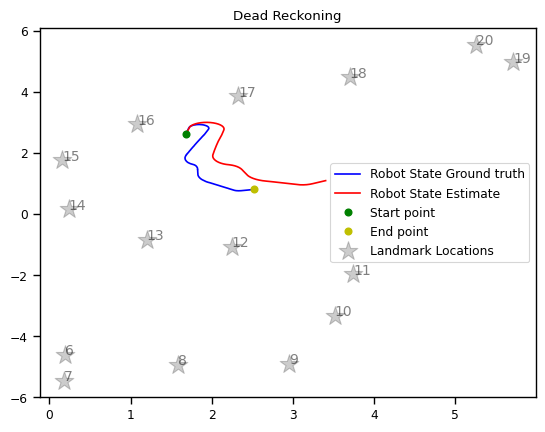

In [15]:
# Define dataset to read
dataset = "data/MRCLAM_Dataset2" # Dataset
end_frame = 3000 # Extension of the dataset
robot = 'Robot3' # Robot

# Build dead reckoning object
self = DeadReckoning(dataset, robot, end_frame)
self.run()

### TASK 1. Inspect the dataset
The objective of this task is to understand how the control inputs used to estimat the robots localization may difer from the actual robot motion.

Go through the following blocks of code while understanding what the different functions do. Add a markdown block after each block of code explaining the what its being done, and add titles and legends to the plots to demonstrate your understanding.

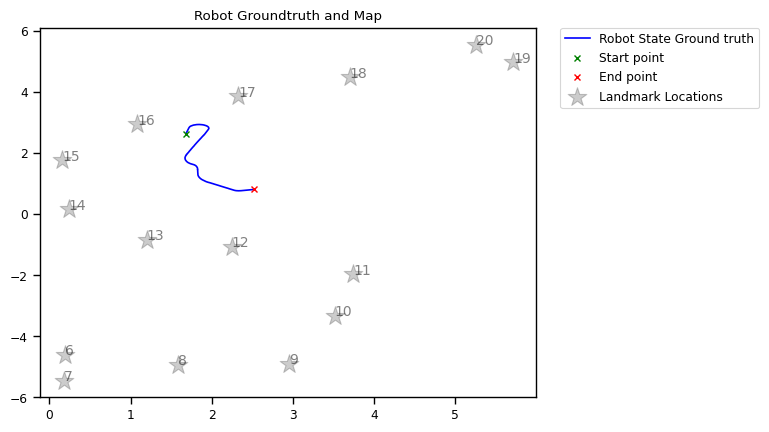

In [16]:
# Build dataframes
self.build_dataframes()

# Represent dataset
self.represent_dataset()

- Builds a timeseries dataframe for the data with the given parameters
- Plots the timeseries data for the ground-truth position of the given robot for the input period</br>and marks the start and end points


##### Plot linear and angular velocity commands
This will be the data that we use to build our motion model

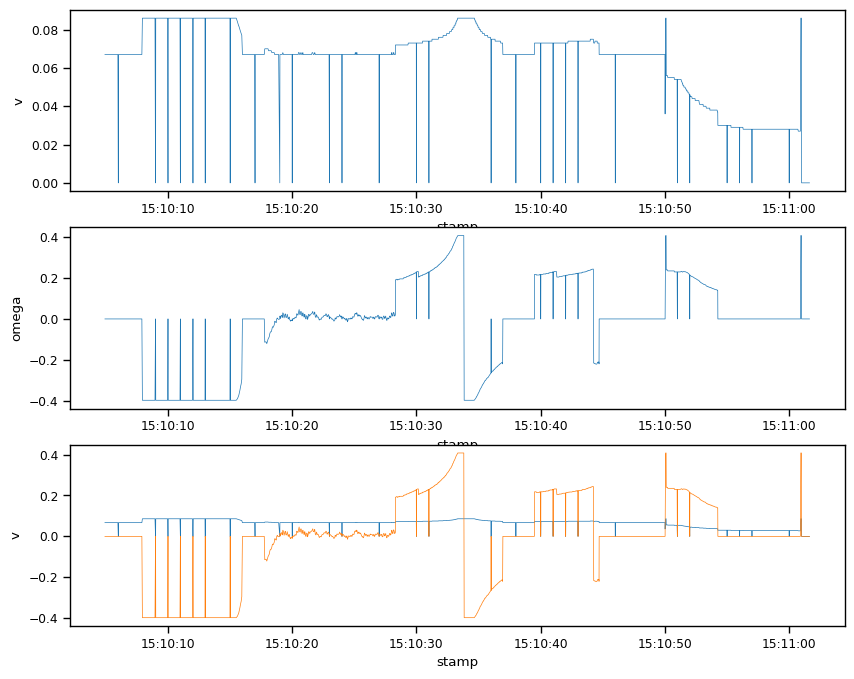

In [17]:
sns.set_context("paper")
fig, axs = plt.subplots(3, 1, figsize=[10,8])
sns.lineplot(data=self.motion, x="stamp", y="v", ax=axs[0], linewidth=0.5)
sns.lineplot(data=self.motion, x="stamp", y="omega", ax=axs[1], linewidth=0.5)
sns.lineplot(data=self.motion, x="stamp", y="v", ax=axs[2], linewidth=0.5)
sns.lineplot(data=self.motion, x="stamp", y="omega", ax=axs[2], linewidth=0.5)
plt.show()

##### Compare with groundtruth

In [14]:
# Generate groundtruth speeds from GT for comparison
self.motion_gt = self.motion.join(self.gt).dropna()
self.motion_gt['dx'] = self.motion_gt['x'].diff()
self.motion_gt['dy'] = self.motion_gt['y'].diff()
self.motion_gt['dtheta'] = self.motion_gt['theta'].diff()
self.motion_gt['dt'] = self.motion_gt.index.to_series().diff().dt.total_seconds()
self.motion_gt['v_gt'] = np.linalg.norm([self.motion_gt['dx'],self.motion_gt['dy']],axis=0)/self.motion_gt['dt']
self.motion_gt['omega_gt'] = self.motion_gt['dtheta']/self.motion_gt['dt']
self.motion_gt.head()

,type,v,omega,x,y,theta,dx,dy,dtheta,dt,v_gt,omega_gt
stamp,,,,,,,,,,,,
2009-07-22 15:10:08.379000064,-1.0,0.086,-0.398,1.721801,2.831794,1.2653,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-22 15:10:11.008999936,-1.0,0.000,0.000,1.805327,2.920559,0.2314,0.083527,0.088766,-1.0339,2.630,0.046344,-0.393118
2009-07-22 15:10:11.172000000,-1.0,0.086,-0.398,1.813401,2.922999,0.1640,0.008074,0.002439,-0.0674,0.163,0.051743,-0.413497
2009-07-22 15:10:16.634000128,-1.0,0.067,0.000,1.956318,2.756269,-1.8605,0.142917,-0.166729,-2.0245,5.462,0.040205,-0.370652
2009-07-22 15:10:18.412000000,-1.0,0.068,-0.041,1.922942,2.639079,-1.8981,-0.033375,-0.117190,-0.0376,1.778,0.068532,-0.021147


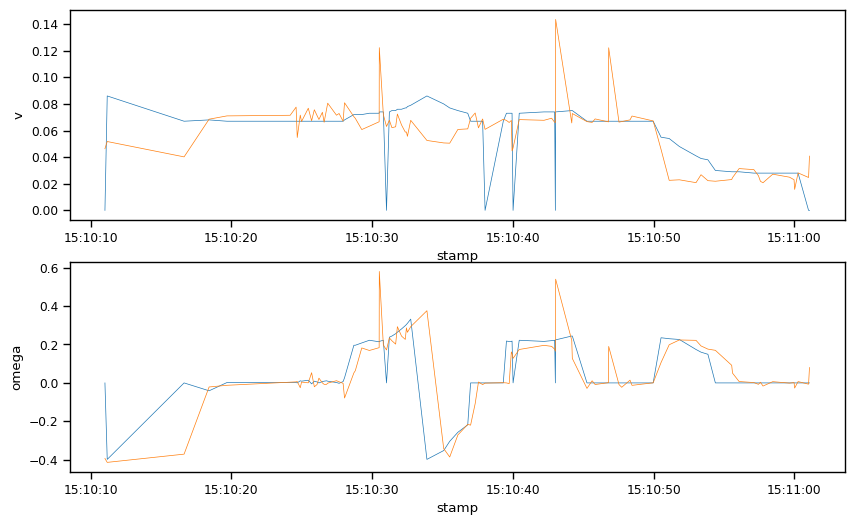

In [15]:
# Plot commands and GT velocities
self.motion_gt = self.motion_gt.dropna()
fig, axs = plt.subplots(2, 1, figsize=[10,6])
sns.lineplot(data=self.motion_gt, x="stamp", y="v", ax=axs[0], linewidth=0.5)
sns.lineplot(data=self.motion_gt, x="stamp", y="v_gt", ax=axs[0], linewidth=0.5)
sns.lineplot(data=self.motion_gt, x="stamp", y="omega", ax=axs[1], linewidth=0.5)
sns.lineplot(data=self.motion_gt, x="stamp", y="omega_gt", ax=axs[1], linewidth=0.5)
plt.show()

<AxesSubplot: xlabel='stamp', ylabel='omega_e'>

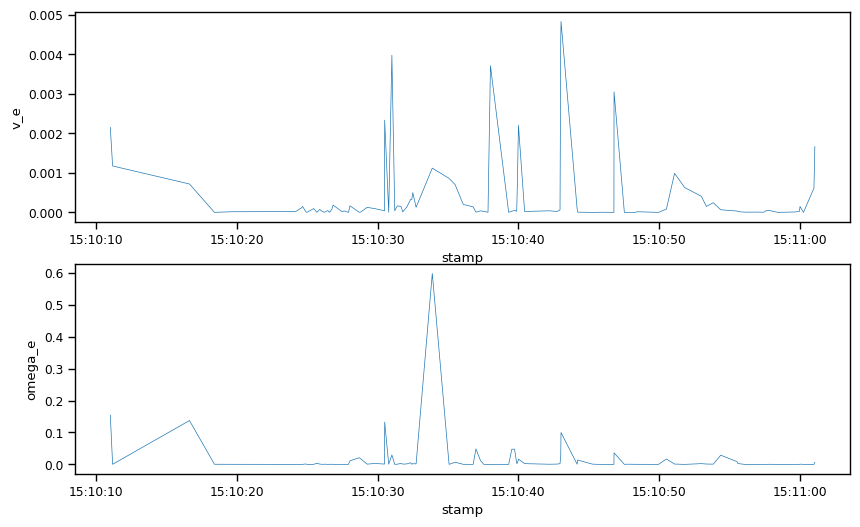

In [16]:
# Get error
self.motion_gt['v_e'] = np.power(self.motion_gt['v_gt'] - self.motion_gt['v'],2)
self.motion_gt['omega_e'] =  np.power(self.motion_gt['omega_gt'] - self.motion_gt['omega'],2)

fig, axs = plt.subplots(2, 1, figsize=[10,6])
sns.lineplot(data=self.motion_gt, x="stamp", y="v_e", ax=axs[0], linewidth=0.5)
sns.lineplot(data=self.motion_gt, x="stamp", y="omega_e", ax=axs[1], linewidth=0.5)


### TASK 2. Estimate localization with dead reckoning

The objective of this task is getting a localization estimate by dead reckoning, and compare the obtained result with the groundtruth using three different error metrics.

Please review what the self.run() function does, and postproces the obtained estimation to get the three error metrics. The errors will be computed as the squared distance between estimation and groundtruth.

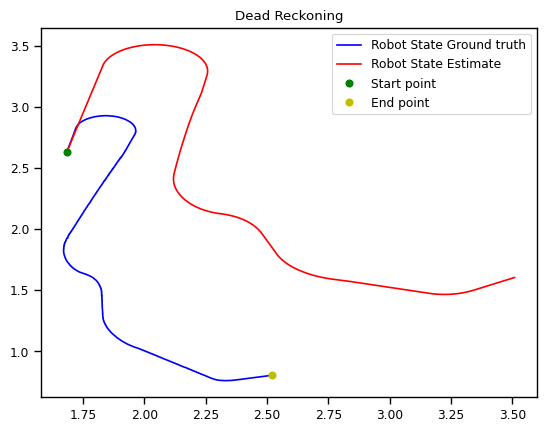

In [17]:
self.run()

In [26]:
states = pd.DataFrame(self.states, columns=['stamp', 'x','y','omega'])
states.head()

,stamp,x,y,omega
0,1.248275e+09,1.683400,2.628217,1.3662
1,1.248275e+09,1.789224,3.138211,1.3662
2,1.248275e+09,1.789918,3.141557,1.3662
3,1.248275e+09,1.790476,3.144247,1.3662
4,1.248275e+09,1.790898,3.146280,1.3662


In [31]:
gt_df = pd.DataFrame(self.groundtruth_data, columns=['stamp', 'x','y','omega'])

In [41]:
joint_df = states.join(gt_df, rsuffix = '_gt')

In [42]:
joint_df.head()

,stamp,x,y,omega,stamp_gt,x_gt,y_gt,omega_gt
0,1.248275e+09,1.683400,2.628217,1.3662,1.248275e+09,1.683400,2.628217,1.3662
1,1.248275e+09,1.789224,3.138211,1.3662,1.248275e+09,1.683364,2.628224,1.3662
2,1.248275e+09,1.789918,3.141557,1.3662,1.248275e+09,1.683444,2.628235,1.3661
3,1.248275e+09,1.790476,3.144247,1.3662,1.248275e+09,1.683452,2.628215,1.3661
4,1.248275e+09,1.790898,3.146280,1.3662,1.248275e+09,1.683468,2.628141,1.3661


#### Normalized accumulated path error
Integral of the error between the estimated localization and the path groundtruth

In [48]:
def normalized_path_error(position):
    d_gt_dis = []
    x_gt = position["x"].tolist()
    y_gt = position["y"].tolist()
    for i in range(len(x_gt) - 1):
        path_error = np.sqrt(np.power(x_gt[i] - x_gt[i+1], 2), np.power(y_gt[i] - y_gt[i+1], 2))
        print(path_error)
        d_gt_dis.append(path_error)


In [49]:
normalized_path_error(joint_df)

TypeError: return arrays must be of ArrayType

#### Maximum path error
Error when the distance between the estimated localization and the path groundtruth is maximum

In [41]:
normalized_path_error(self.motion_gt[["x", "y"]], 0)

[1.8053272, 1.8134009, 1.9563178, 1.9229425, 1.8923992, 1.7885063, 1.7791175, 1.77765, 1.772884, 1.7701275, 1.7592893, 1.7537858, 1.7496366, 1.7459809, 1.7425701, 1.7373486, 1.7354039, 1.7311108, 1.7285997, 1.7151331, 1.7117872, 1.7050383, 1.7031368, 1.6881943, 1.6882403, 1.6796535, 1.6730296, 1.6712486, 1.6708865, 1.6714086, 1.6730142, 1.6748613, 1.676809, 1.6805488, 1.6827796, 1.688755, 1.6945937, 1.6964454, 1.69854, 1.7058825, 1.7444877, 1.7905035, 1.8017356, 1.8146661, 1.8231325, 1.8249443, 1.8262522, 1.8255698, 1.8264811, 1.8268427, 1.8289903, 1.8293297, 1.8298216, 1.8298967, 1.8301012, 1.8297213, 1.8322207, 1.8666646, 1.8853316, 1.8931763, 1.8952666, 1.8966085, 1.9472153, 1.9498139, 2.0045717, 2.0230783, 2.0347019, 2.0833147, 2.0841441, 2.1224467, 2.1327102, 2.1624418, 2.1704562, 2.248621, 2.2687903, 2.2793966, 2.2932327, 2.3172248, 2.3267554, 2.3376688, 2.3492457, 2.3755715, 2.3770626, 2.3912388, 2.4222775, 2.4304413, 2.433483, 2.4371619, 2.4553393, 2.4840031, 2.4913238, 2.49189

#### Final position error
Error between the estimated localization and the path groundtruth at the end of the path

### TASK 3. Iterate over diferent datasets
Here we are interested on executing multiple experiments using different robots and datasets and get the three error metrics from previous blocks for all the experiments and enable further analisis of this errors.

The iterative execution of different experiments will enable as to compare different localization algorithms on further lab sessions.

#### Generate metrics

In [12]:
datasets = ["../data/MRCLAM_Dataset1",
            "../data/MRCLAM_Dataset2",
            "../data/MRCLAM_Dataset3",
            "../data/MRCLAM_Dataset4"]
robots = ['Robot1',
          'Robot2',
          'Robot3',
          'Robot4']

errors = pd.DataFrame(columns=['dataset','robot','acc?error','max_error','final_error'])

#for ds in datasets:
   #for rob in robots:
        # Load data
        
        # Get the three errors

#### Represent metrics
Use seaborn library (catplot)

In [13]:
# Represent metrics for all experiments

#### Analize metrics

In [14]:
# Analize the results and provide the mean error metrics across the experiments performed.